##  Product Reviews and Ratings Analysis

This Project is an application of Bag of Words, Principal Component Analysis and Logistic Regression. The end goal is to predict product ratings from review text.

#### Bag of Words 
Bag of Words (BOW) is a way of extracting features from text for use in modeling, such as with machine learning algorithms. It is a representation of text that describes the occurrence of words within a document. It involves two things: 1. A vocabulary of known words. 2. A measure of the presence of known words. 

#### About Project
This project consists of 4 parts.
- Part 1: Create a bag-of-word vector representation for each review
- Part 2: Run a PCA (Principal component analysis) and graph the first two PCs for the first 100 reviews.
- Part 3: Use logistic regression to predict the rating (5 levels) of a product.
- Data is from ecommerce website and consists of:
<br> - reviewerID
<br> - asin (ID of the product) 
<br> - reviewerName
<br> - helpful (helpfulness rating of the review, e.g. 2 out of 3 people found the review to be helpful. The dataframe below would have 2 in the helpful_start column and 3 in the helpful_end column)
<br> - overall (rating of the product)
<br> - summary (summary of the review) 
<br> - unixReviewTime (time of the review)

In [64]:
# load packages
import io
import ijson
import pandas as pd
import datetime
import nltk
import re
import textblob
import string
import numpy as np
import scipy.spatial.distance as scipydist
import matplotlib.pyplot as plt
import itertools  
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from tqdm._tqdm import trange
from spellchecker import SpellChecker
from autocorrect import Speller
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mord import LogisticAT
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [3]:
# import data
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]
reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

a = datetime.datetime.now()

with open('reviews_electronics.4.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)

c=b-a
print(c.seconds)

48


In [45]:
reviews = review.copy()
reviews.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,A22X9YQ3YPRUIJ,B000WW1YVU,T. Nelson,4,4,I live in L.A./Orange County CA area with LOTS...,2.0,Power Boost for Belkin TuneBase FM With Clears...,1202428800,"02 8, 2008"
2,A2T0MTHNOFBPQ,B000WW1YVU,Tomy,1,3,I bought this product (I did not buy from amaz...,1.0,I do not recommend to buy this product.,1270425600,"04 5, 2010"
3,A3QS4VQPONP1RZ,B000WW1YVU,Tricia,0,0,For years I had a cheaper Belkin TuneBase tran...,3.0,Pricier but not better,1390176000,"01 20, 2014"
4,AQFDX78HMJ6DU,B000WW1YVU,TWC42,2,2,There are no clear areas on the FM dial in the...,1.0,No clear channel in DC Metro area,1239321600,"04 10, 2009"


#### Part 1
#### 1.1 Handle lower/upper case and stopwords
- Treat each review as a document. Ignore misspellings. Convert all reviews to lower case. Remove stop words (use package to do this).
- Use NLTK's stopwords library. An additional step is added - remove "not" and "xxxn't" (e.g., don't, didn't etc.) from remove stopwords "not" and "xxxn't". This is to ensure these words are not excluded from the final review text.

In [46]:
# lower case
reviews["reviewText"] = reviews["reviewText"].apply(str.lower)

In [47]:
# load stopwords
nltk.download('stopwords')
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# remove "not" and "xxxn't" from stopwords
rx_not = re.compile(r'not')
rx_nt = re.compile(r"[a-z]+n't")
stops = [i for i in stops if not rx_not.match(i) and not rx_nt.match(i)]
stops = set(stops)

In [49]:
# remove stopwords
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: ' '.join([item for item in x.split() if item not in stops]))

#### 1.2 Handle Negations

- Look for the following two negations: "not" and "xxxn't". Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". 
- Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword".

In [50]:
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: re.sub(r"(not)(\s)(\w+)",r"not_\3",str(x)))
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: re.sub(r"(\s)([a-z]*)(n't)(\s)(\w+)",r"\1not_\5",str(x)))

In [51]:
# take a look at an example of the result
reviews["reviewText"][8]

'so, use charge ipod car fm transmission horrible distracting frustrating listen driving. open remove inductor see get better fm signal.now tried fm transmitter, not_think ever good enough frustration free long distance driving ipod listening. best thing aux line, 2006 corolla not_one. time new car. ha!'

#### 1.3 Stemming
Stem all words using Porter 1979 (use package to do this).

In [52]:
ps = PorterStemmer() 

In [53]:
# stem words
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: ' '.join([ps.stem(item) for item in x.split()]))

In [54]:
# take a look at an example of the result
reviews["reviewText"][0]

'corey barker great job explain blend mode dvd. kelbi train video great pricey buy individually. realli want bang buck subscrib kelbi train online.'

#### 1.4 Frequency count
- Create frequency count table for all word stems in all reviews. Use the most frequent 500 words to define the word vector. 
- Create a bag-of-word vector representation for each review. Each row represents a review text.

In [55]:
# tokenize
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: nltk.word_tokenize(x))

In [56]:
# remove apostrophes
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: " ".join([word.strip(string.punctuation) for word in x]))

In [57]:
# concat all words in all reviews
words = reviews["reviewText"].str.cat(sep=' ')

In [58]:
# frequency count
word_dist = nltk.FreqDist(words.split())

In [62]:
# most frequent 500 words
most_freq = dict(word_dist.most_common(500))

In [66]:
# printing result   
top_10_freq = dict(itertools.islice(most_freq.items(), 10))         
print("Top 10 Frequent Words: \n" + str(top_10_freq))  

Top 10 Frequent Words: 
{'use': 282651, 'work': 215975, 'one': 198732, 'great': 182637, 'i': 177194, 'would': 150331, 'get': 148237, 'good': 143308, 'it': 133868, 'like': 130561}


In [68]:
# bag-of-word vector
# each row represents a reviewtext
vectorizer = CountVectorizer(most_freq, max_features = 500)
bow_vector = vectorizer.fit_transform(reviews["reviewText"]).toarray()
pd.DataFrame(bow_vector).head() 

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


Measure the Euclidean distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from closest to furthest.

In [69]:
first_100 = pd.DataFrame(bow_vector).loc[0:99]
dist_euclid = scipydist.pdist(first_100, metric='euclidean')
dist_euclid= np.sort(dist_euclid)
dist_euclid_df = pd.DataFrame(scipydist.squareform(dist_euclid))

In [71]:
dist_euclid_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,2.449490,2.449490,2.645751,2.645751,2.645751,2.828427,3.000000,3.000000,3.000000,...,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102
1,2.449490,0.000000,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.605551,...,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657
2,2.449490,3.464102,0.000000,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
3,2.645751,3.464102,3.741657,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641
4,2.645751,3.464102,3.741657,4.000000,0.000000,4.242641,4.242641,4.242641,4.242641,4.242641,...,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899


#### Part 2 
Run a PCA (Principal component analysis) and graph the first two PCs for the first 100 reviews.

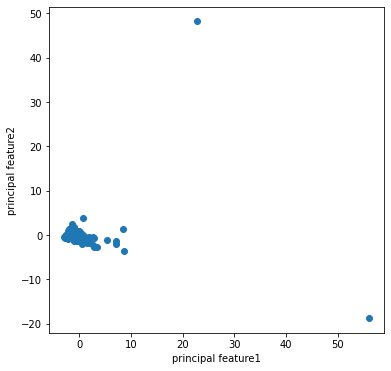

In [72]:
x = StandardScaler().fit_transform(first_100)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

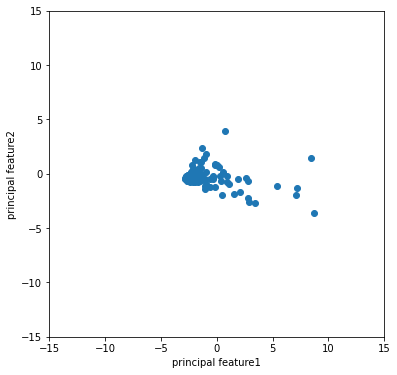

In [73]:
# Zoom-in
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.show();

From the graph, we see most of the points have PCA 1 , 2 ranging from -5 to 5. In 1.4, we find that Euclidean distance between reviews range from 2.45 to 33.0. Consider that we have 500 words, the range is quite small. This is also reflected in the PCA plot where the points are clustered and the first component explains most of the variation.  
 

#### Part 3
- Use logistic regression to predict the rating (5 levels) of a product. Rating is an ordinal variable.
- Measure the out-of-sample accuracy of the prediction.

In [75]:
y = reviews["overall"].astype(int)
x_bow = StandardScaler().fit_transform(pd.DataFrame(bow_vector))
x_bow = pd.DataFrame(x_bow)

In [78]:
x_bow_train,x_bow_test,y_train,y_test=train_test_split(x_bow, y, test_size=0.1, random_state=31)
ordlogit_lasso = LogisticAT(alpha=1)
ordlogit_lasso.fit(x_bow_train, y_train)
ordlogit_lasso_predictions = ordlogit_lasso.predict(x_bow_test)
accuracy = accuracy_score(y_test, ordlogit_lasso_predictions)
print('Ordered logistic regression (train/test split: 9/1): ', accuracy)

Ordered logistic regression (train/test split: 9/1):  0.5260730612079777


In [79]:
acc = make_scorer(accuracy_score)
accuracy_cv = cross_val_score(ordlogit_lasso, x_bow, y, cv = 3, scoring=acc)
print('Ordered logistic regression (3-fold cv): ', np.mean(accuracy_cv))

Ordered logistic regression (3-fold cv):  0.5220936418453274


Thus Out of Sample accuracy for logistic model = **52%**